<a href="https://colab.research.google.com/github/Amyano/mini4/blob/master/Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/'My Drive'/'COMP551-Mini4'/   

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
CIFAR.pt       images	     mask_bear1.png  mask_bear3.png
cifarvgg13.bt  img_bear.jpg  mask_bear2.png  RestrictedImageNet.pt


In [0]:
datapath = 'gdrive/My Drive/COMP551-Mini4/'
file_vgg = datapath + "cifarvgg13.bt"
file_cifar = datapath + "CIFAR.pt"

In [3]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
!pip install robustness
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
%matplotlib inline

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 460kB 19.9MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 194kB 44.9MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=f95c1cf841f7d8b3153975561871159d676997245168212b81c2b053396bd570
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [0]:
# Constants
DATA = 'CIFAR'
BATCH_SIZE = 10
NUM_WORKERS = 8
NUM_CLASSES_VIS = 10

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
NUM_CLASSES_VIS = min(NUM_CLASSES_VIS, NUM_CLASSES)
GRAIN = 4 if DATA != 'CIFAR' else 1

In [5]:
import torch
use_gpu=torch.cuda.is_available()
print("GPU Available:{}".format(use_gpu))

GPU Available:True


In [6]:
ds = datasets.CIFAR('datapath')
_, test_loader = ds.make_loaders(workers=NUM_WORKERS,
                                    batch_size=BATCH_SIZE)
data_iterator = enumerate(test_loader)

0it [00:00, ?it/s]

==> Preparing dataset cifar..


170500096it [00:06, 25688854.51it/s]                               


Extracting datapath/cifar-10-python.tar.gz to datapath
Files already downloaded and verified


In [0]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [8]:
im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_loader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = ch.cat(im_test), ch.cat(targ_test)

conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


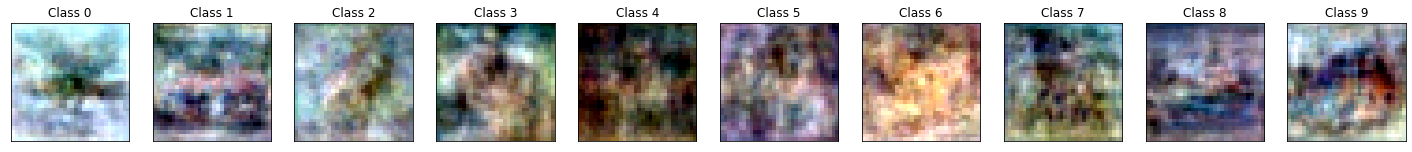

In [9]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
img_seed = ch.clamp(img_seed, min=0, max=1)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

In [0]:
def generation_loss(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
    return loss, None

kwargs = {
        'custom_loss': generation_loss,
        'constraint':'2',
        'eps': 40,
        'step_size': 1,
        'iterations': 60,
        'targeted': True,
}  
    
if DATA == 'CIFAR':
    kwargs['eps'] = 30
    kwargs['step_size'] = 0.5
    kwargs['iterations'] = 60

In [0]:
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [12]:
model, _ = model_utils.make_and_restore_model(arch="resnet50", dataset=ds,
             resume_path=file_cifar)
model.eval()

=> loading checkpoint 'gdrive/My Drive/COMP551-Mini4/CIFAR.pt'
=> loaded checkpoint 'gdrive/My Drive/COMP551-Mini4/CIFAR.pt' (epoch 153)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

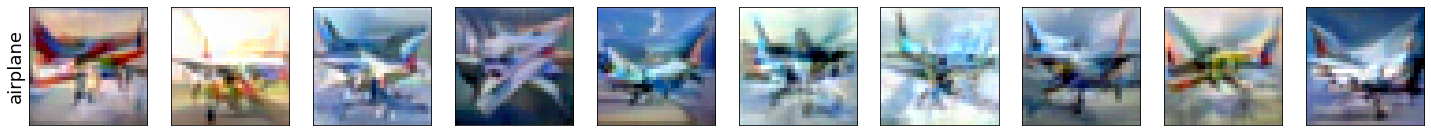

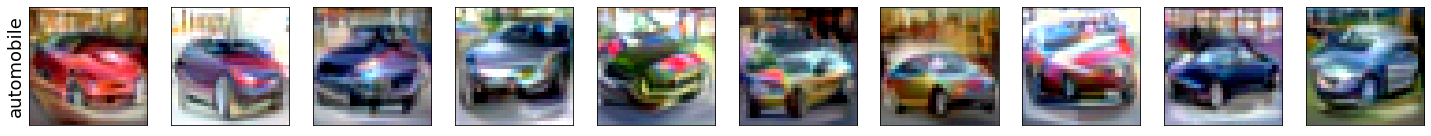

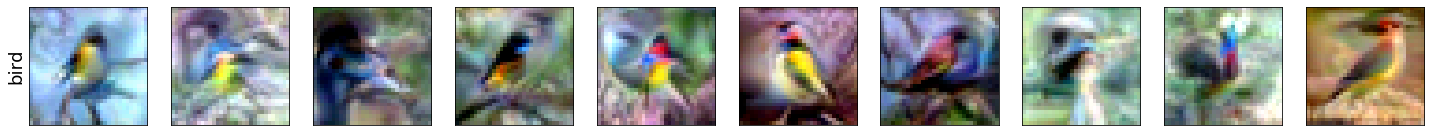

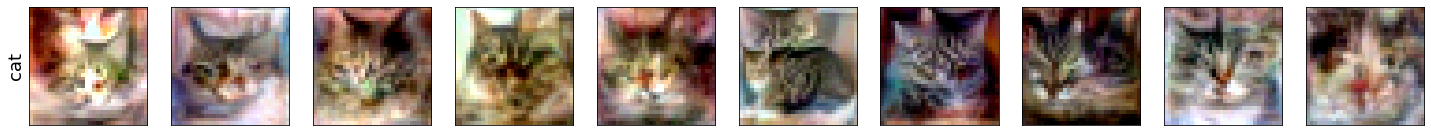

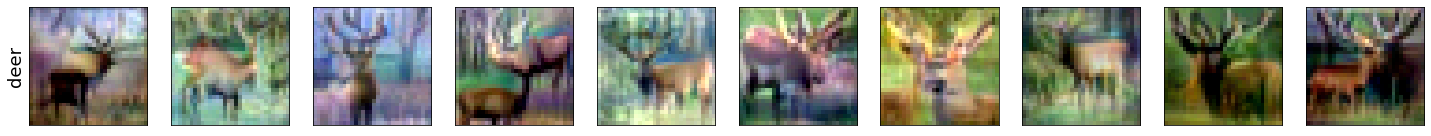

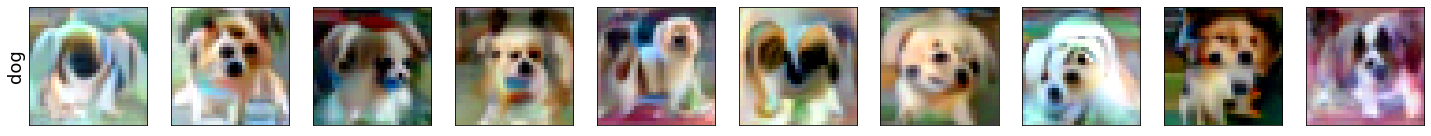

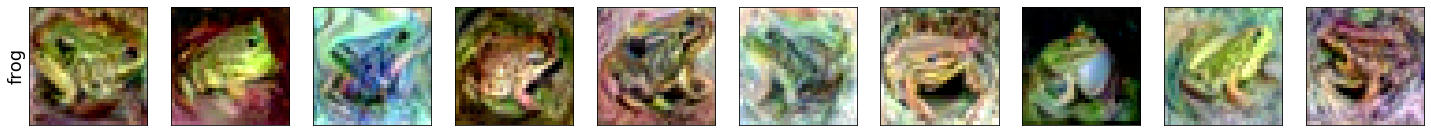

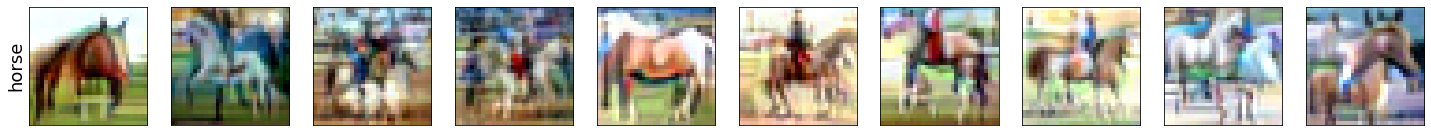

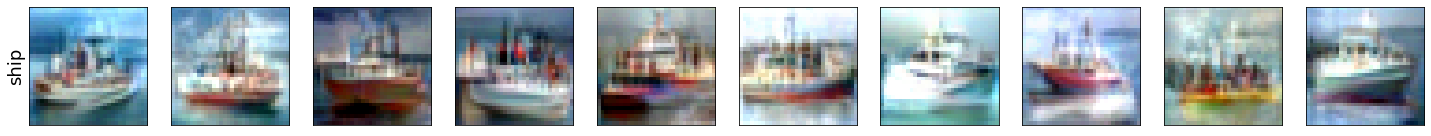

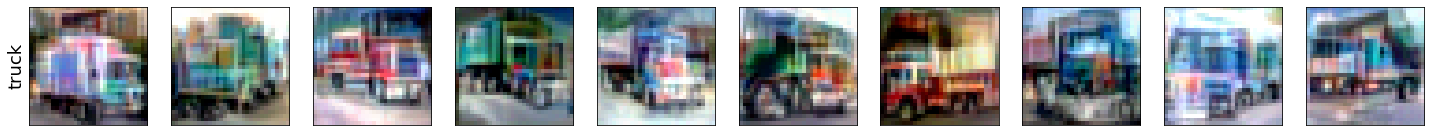

In [13]:
img_list = []

show_seed = False
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, )) 
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed, target_class.long(), make_adv=True, **kwargs)
    
    for j in range(im_gen.cpu().shape[0]):
      img = im_gen.cpu()[j,:,:,:]
      img_list.append(img)
      
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   [CLASSES[int(t)].split(',')[0] for t in target_class], 
                   fontsize=18)

In [14]:
m,std = inception_score(img_list, batch_size=10, resize=True)
m

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:06<00:00, 15.9MB/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


3.996086478271913

In [15]:
model, _ = model_utils.make_and_restore_model(arch="vgg13", dataset=ds,
             resume_path=file_vgg)
model.eval()

=> loading checkpoint 'gdrive/My Drive/COMP551-Mini4/cifarvgg13.bt'
=> loaded checkpoint 'gdrive/My Drive/COMP551-Mini4/cifarvgg13.bt' (epoch 56)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [0]:
!mkdir -p '/content/gdrive/My Drive/COMP551-Mini4/images'
output_dir = '/content/gdrive/My Drive/COMP551-Mini4/images/'

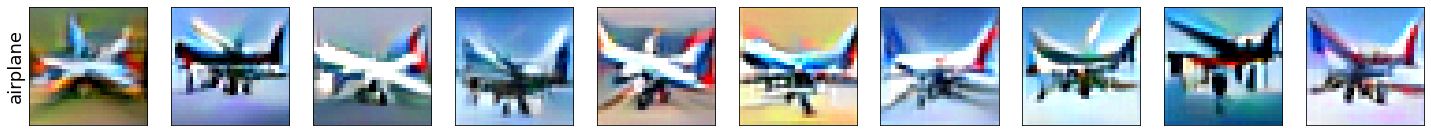

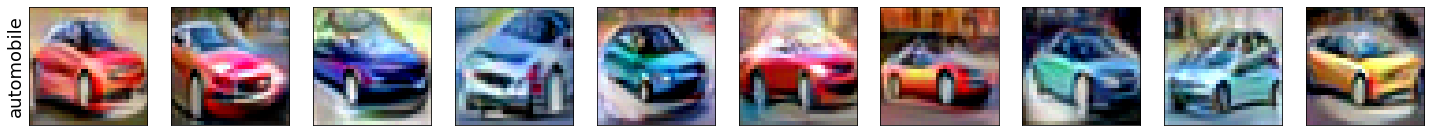

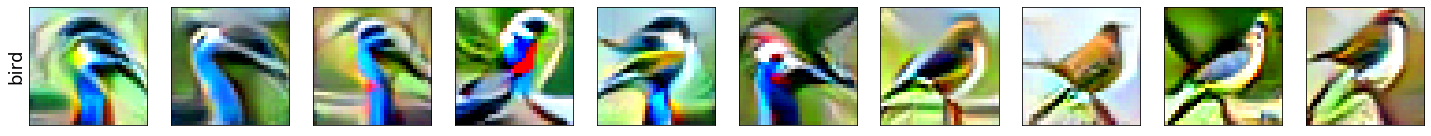

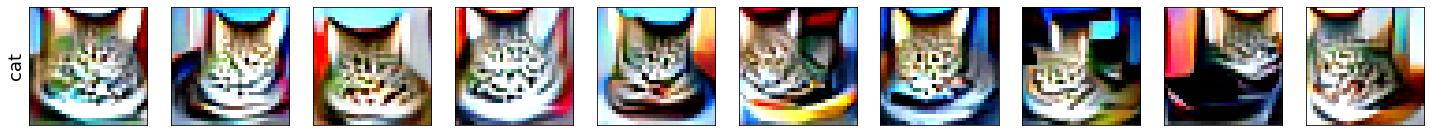

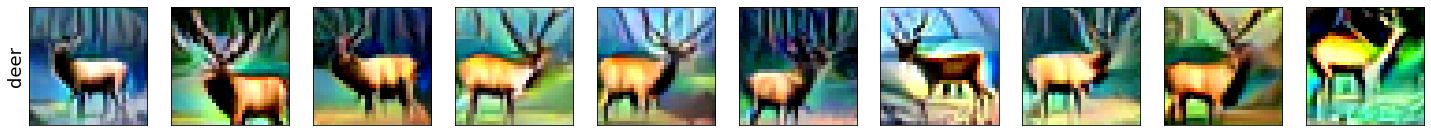

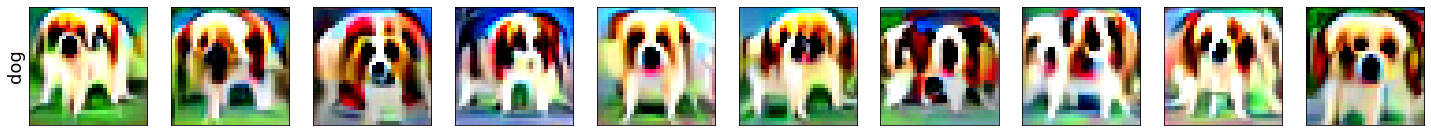

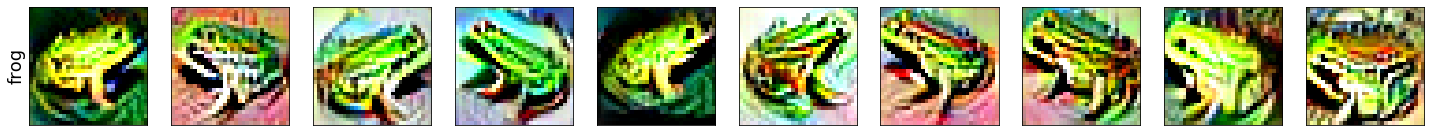

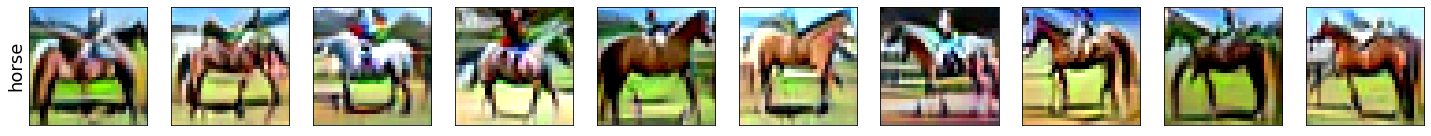

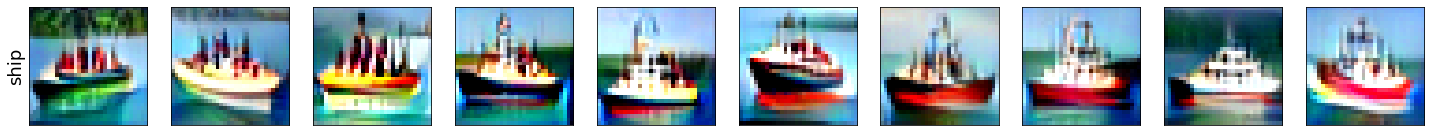

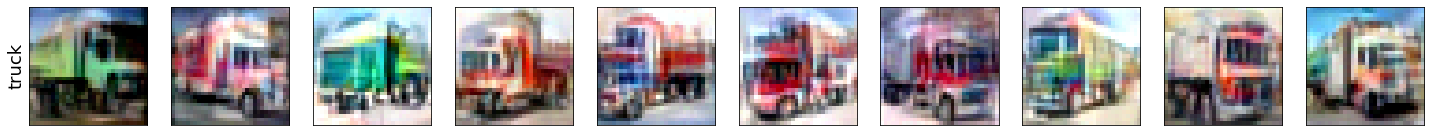

In [17]:
img_list = []
show_seed = False
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, )) 
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed, target_class.long(), make_adv=True, **kwargs)
    
    for j in range(im_gen.cpu().shape[0]):
      img = im_gen.cpu()[j,:,:,:]
      img_list.append(img)

    #x = im_gen.cpu().permute(0, 2, 3, 1)
    #for j in range(x.shape[0]):
      #img = x[j,:,:,:]
      #img = img.numpy()
      #plt.imshow(img)
      #plt.axis('off')
      #plt.imsave(output_dir+"%d-%d.jpg"%(i, j), img)
      #plt.show()

    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   [CLASSES[int(t)].split(',')[0] for t in target_class], 
                   fontsize=18)

In [18]:
m,std = inception_score(img_list, batch_size=10, resize=True)
m

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


5.67463698590177